# Problem 1: K-means clustering and image compression (4pts)

### <div align="right"> &copy; Markiian Novosad & Rostyslav Hryniv, 2022 </div>

## Completed by:   
*   Ivan Havlytskyi
*   Oleksandr Kharytonov



### Description:
The aim of this assignment is to understand the K-means clustering algorithm and how it is used for image compression. You will implement the algorithm and then use it to assign the $m\times m$ blocks of the given image in $k$ clusters and then replace each block with the respective centroid. Visually, the quality of the image does not deteriorate much for moderate $m$ and large enough $k$, while its size drops down significantly as we only have to store the $k$ centroids and the cluster allocations of the blocks


### Links
For this task of your homework you can get **4 points** plus extra (see the last part). Do not forget to save and rename the notebook before making any changes!


To do some preliminary reading about K-Means algorithm, please check the following links:
*   https://scikit-learn.org/stable/modules/clustering.html
*   https://towardsdatascience.com/image-compression-using-k-means-clustering-aa0c91bb0eeb


### Initialization

In [1]:
from PIL import Image
import requests
from io import BytesIO

url = "https://images.unsplash.com/photo-1611915387288-fd8d2f5f928b?ixlib=rb-4.0.3&w=1080&fit=max&q=80&fm=jpg&crop=entropy&cs=tinysrgb"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

In [2]:
import torch
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

import numpy as np

In [3]:
def to_patches(img: torch.Tensor, psize) -> np.ndarray:
  return img.unfold(1, size=psize, step=psize).unfold(2,size=m, step=m).flatten(1,2).permute(1,0,2,3).numpy()

def visualize_patches(patches: np.ndarray, true_image_size=512, padding=0) -> Image:
  patch_tensor = torch.from_numpy(patches)
  return Image.fromarray(
      make_grid(patch_tensor, nrow=true_image_size // patches.shape[2], padding=padding
                ).permute(1,2,0).mul(255).to(torch.uint8).numpy())

## 1. K-Means Clustering from scratch (1.5 pt)

In this part, you will have to implement K-Means clustering algorithm for a dataset of points in $\mathbb{R}^n$. To this end, you are asked to implement the following methods:

*   random centroid initialization (choose random dataset points)
*   distance function
      *   Implement private methods with different distance metric (Euclidean, $\ell_1$, cosine, etc.)
*   allocation of points to clusters for given centroids
*   centroids update based on distance to all data points in respective clusters
*   and, finally, implement K-Means fitting loop, wich returns new fitted centroids





### Task 1: Complete the code below

In [4]:
import random
import numpy as np
from scipy.spatial.distance import cdist

class KMeans:

  def __init__(
      self,
      num_clusters=1,
      num_features=1,
      max_iter=1000,
      epsilon=1e-6,
      dist_metric="euclidean"
    ) -> None:
    self.K = num_clusters
    self.C = num_features
    self.I = max_iter
    self.E = epsilon
    self.metric = dist_metric

  def init_centroids(self, X: np.ndarray) -> np.ndarray:
    """
    Initialize centroids in random manner
    """
    assert (self.C) == X.shape[1]
    centroids = np.zeros((self.K, self.C))
    # ========= YOUR CODE STARTS HERE ========= #

    random_indices = np.random.choice(
      X.shape[0], size=self.K,
      replace=False # to avoid duplicate centroids
      )

    centroids = X[random_indices].copy()

    # ========== YOUR CODE ENDS HERE ========== #
    return centroids

  def dist(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute distance from each point to each centroid,
    depending on a self.metric type
    """
    # ========= YOUR CODE STARTS HERE ========= #

    return cdist(X, centroids, metric=self.metric) # already was imported

    # ========== YOUR CODE ENDS HERE ========== #


  def calc_mask(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute distance between data and centroids, pick closest centroid for each
    data point.
    """
    return self.dist(X, centroids).argmin(-1) # FIXED .sum(-1) -> consider storing centroids each on separate axis

  def update_clusters(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute new centroids, by computing the mean of each centroid's cluster.

    Hint: Beware, with high value of K, some clusters centroid's can become
    redundant, and have no points belonging to them.
    """
    mask = self.calc_mask(X, centroids)
    new_centroids = np.zeros_like(centroids)

    # ========= YOUR CODE STARTS HERE ========= #

    onehot_mask = (mask == np.arange(self.K).reshape(-1,1))
    onehot_clusters = X * onehot_mask[...,np.newaxis] # new axis with num_clusters number of coords to place each vector on separate coord based on the cluster (zeros else)

    new_centroids = onehot_clusters.sum(axis=1) / onehot_mask.sum(axis=1)[...,np.newaxis]

    # ========== YOUR CODE ENDS HERE ========== #

    return new_centroids

  def predict(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    mask = self.calc_mask(X, centroids)
    return centroids[mask]

  def fit(self, X: np.ndarray) -> np.ndarray:
    """
    Implement training loop that looks like this:
    -- intiialize new centroids
    -- for max_iter steps:
      -- update centroids
      -- compute delta between old and new centroids
      -- return centroids if delta < epsilon

    """
    # return None
    # ========= YOUR CODE STARTS HERE ========= #

    centroids = self.init_centroids(X)

    for i in range(self.I):
      new_centroids = self.update_clusters(X, centroids)
      
      delta = np.linalg.norm(new_centroids - centroids)
      if delta < self.E:
        return new_centroids
      
      centroids = new_centroids

    return centroids
    # ========== YOUR CODE ENDS HERE ========== #


## 2. Image compression using K-Means clustering (0.5 pt)

The dataset for clustering will be the $m\times m$ patches of the initial image. We split the image into patches with helper function **to_patches()**

In [5]:
m = 16 # size of patch
img = img.resize((512,512))
img_tensor = ToTensor()(img) # 3, 512, 512

patches = to_patches(img_tensor, m)
patches.shape

(1024, 3, 16, 16)

Let's see how our splitted image looks:
(You can change padding from 0 to another value, to see the grid)

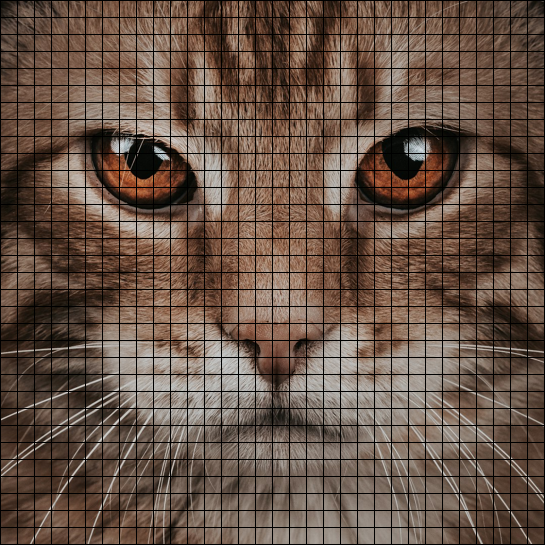

In [6]:
visualize_patches(patches, padding=1)

In [7]:
# convert patch data to feature vectors
data = patches.reshape(patches.shape[0], -1)
data.shape

(1024, 768)

### Try out your implementation!

In [8]:
# initialize KMeans algo
kmeans = KMeans(128, data.shape[-1], max_iter=400)
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)


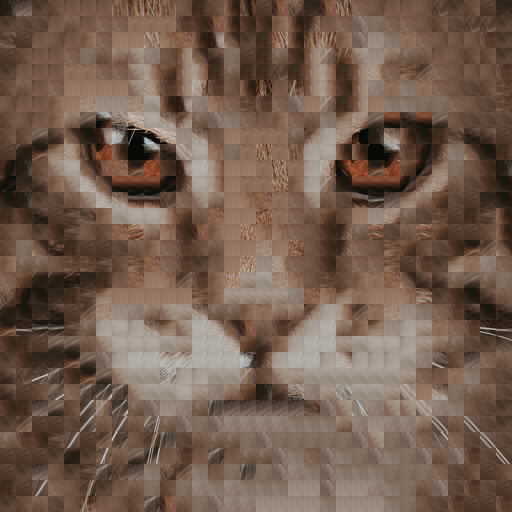

In [9]:
visualize_patches(predicted.reshape(-1,3,m,m))

### Task 2: Discussion (0.5 pt)

 Using the implemented image compression algorithm, discuss the following topics:
1.  **Distance Metrics**: how do they influence of distance metrics on final result of fitting? (Provide visualizations and comments)
2.  **Compression rate**: what is the compression rate with different **k** (1,2,...,32) and **m**? What compression rate can we achieve without losing much quality?

---

\### **YOUR ANSWER HERE** \###

---

In [10]:
distances = ['cityblock', 'euclidean', 'chebyshev', 'cosine']

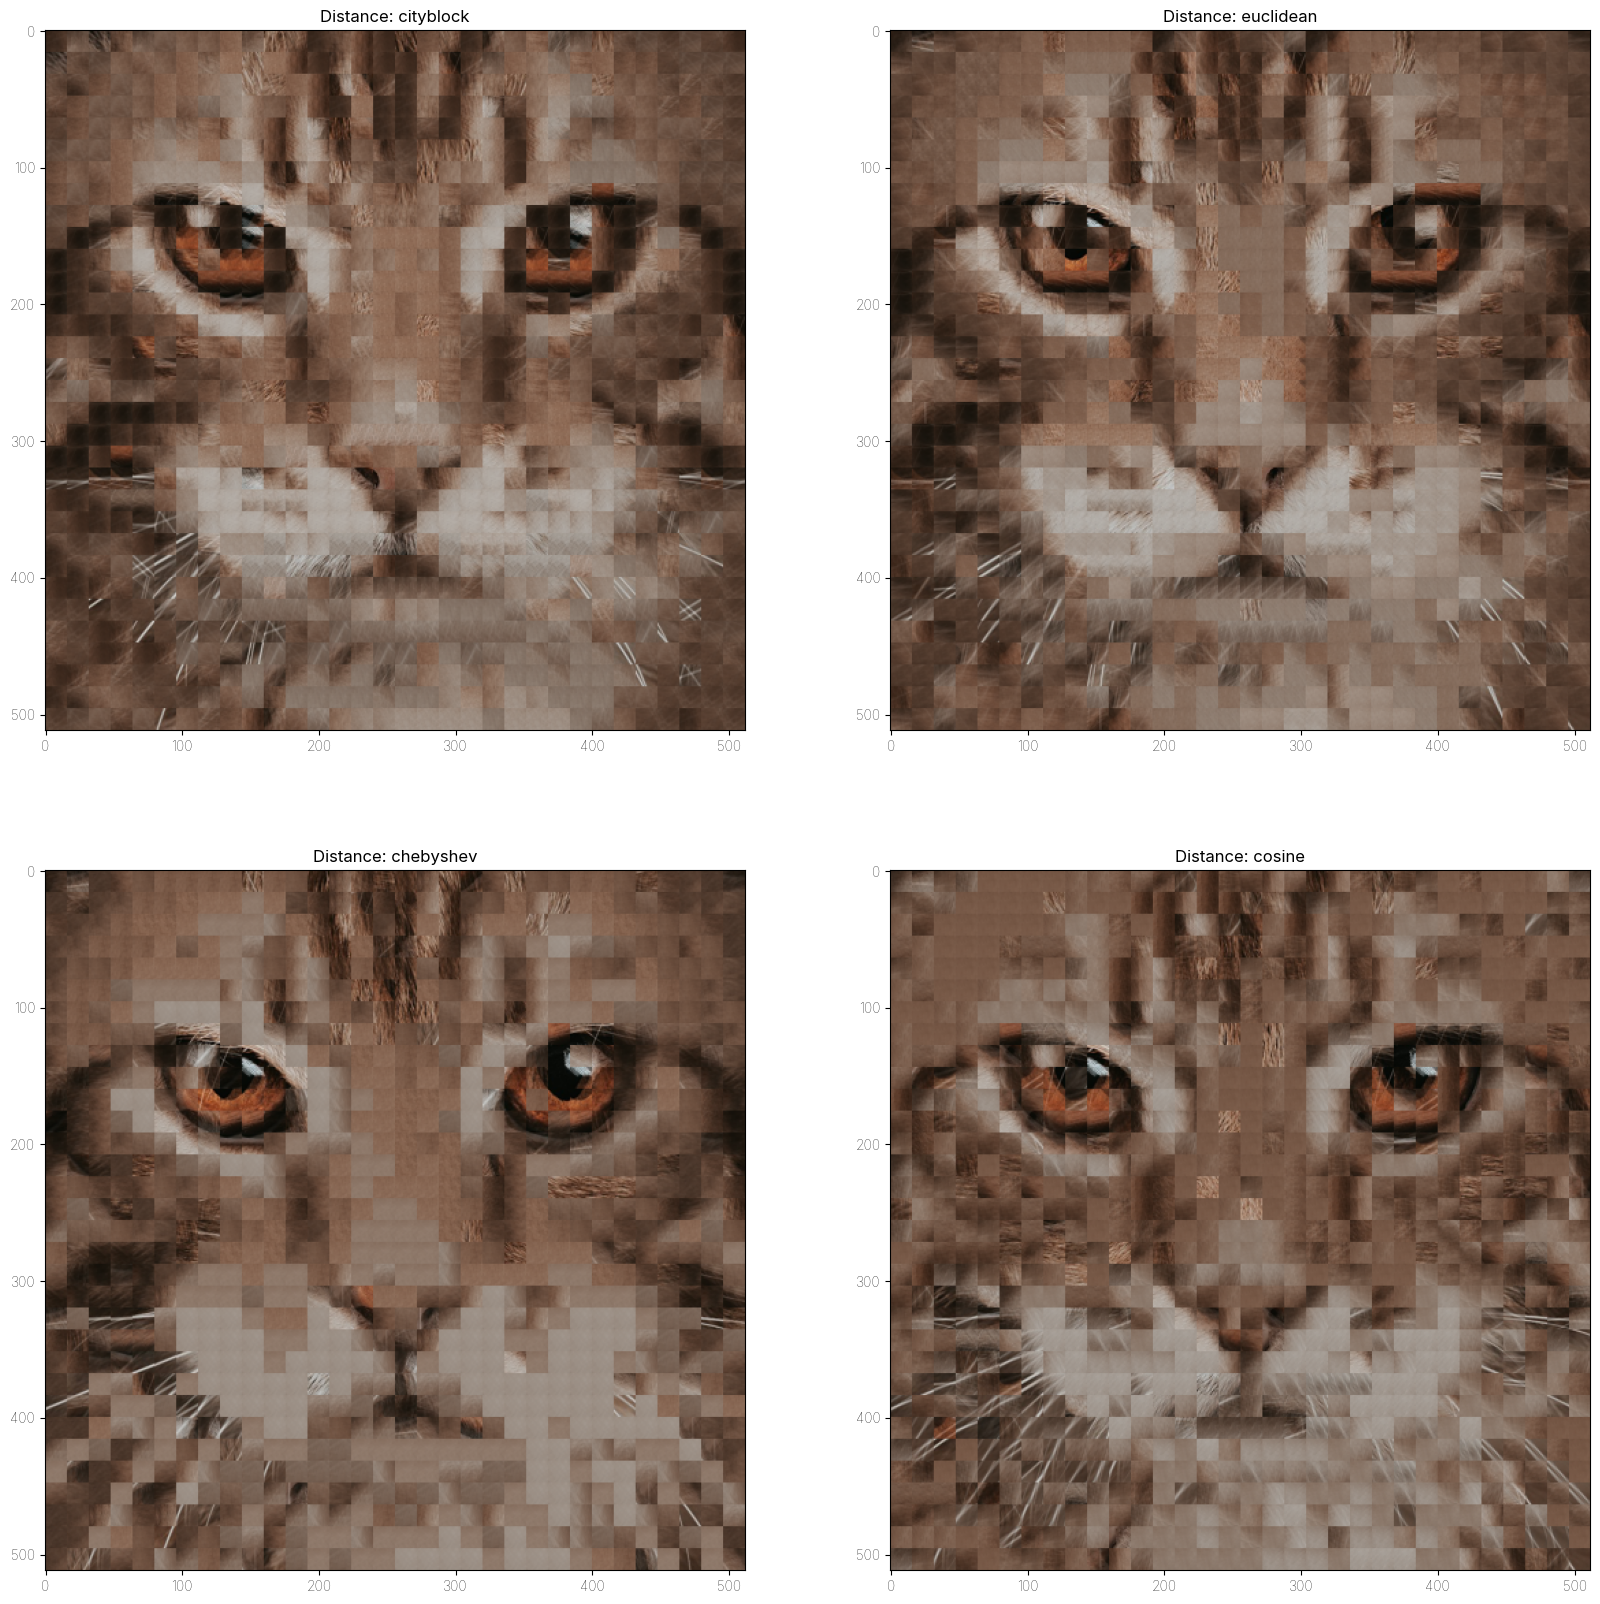

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs = axs.flatten()


for ii, dist in enumerate(distances):
    kmeans = KMeans(128, data.shape[-1], max_iter=400, dist_metric=dist)
    centroids = kmeans.fit(data)
    predicted = kmeans.predict(data, centroids)

    axs[ii].imshow(
        visualize_patches(
            predicted.reshape(-1,3,m,m)
        )
    )
    axs[ii].set_title(f'Distance: {dist}')

- Euclidean -- the normal and default choice (our baseline for comparison).

- Cityblock -- sharper edges.

- Cosine -- flattens brightness.

- Chebyshev -- the worst one (vibrissae part).

  0%|          | 0/3 [00:00<?, ?it/s]

[m= 8, k= 16] fit_time = 0.362 s


[m= 8, k= 32] fit_time = 0.681 s


[m= 8, k= 64] fit_time = 2.143 s


 33%|███▎      | 1/3 [00:06<00:12,  6.35s/it]

[m= 8, k=128] fit_time = 3.074 s


[m=16, k= 16] fit_time = 0.152 s


[m=16, k= 32] fit_time = 0.320 s


[m=16, k= 64] fit_time = 0.425 s


 67%|██████▋   | 2/3 [00:07<00:03,  3.53s/it]

[m=16, k=128] fit_time = 0.595 s


[m=32, k= 16] fit_time = 0.193 s
[m=32, k= 32] fit_time = 0.147 s


[m=32, k= 64] fit_time = 0.195 s


100%|██████████| 3/3 [00:08<00:00,  2.94s/it]

[m=32, k=128] fit_time = 0.334 s


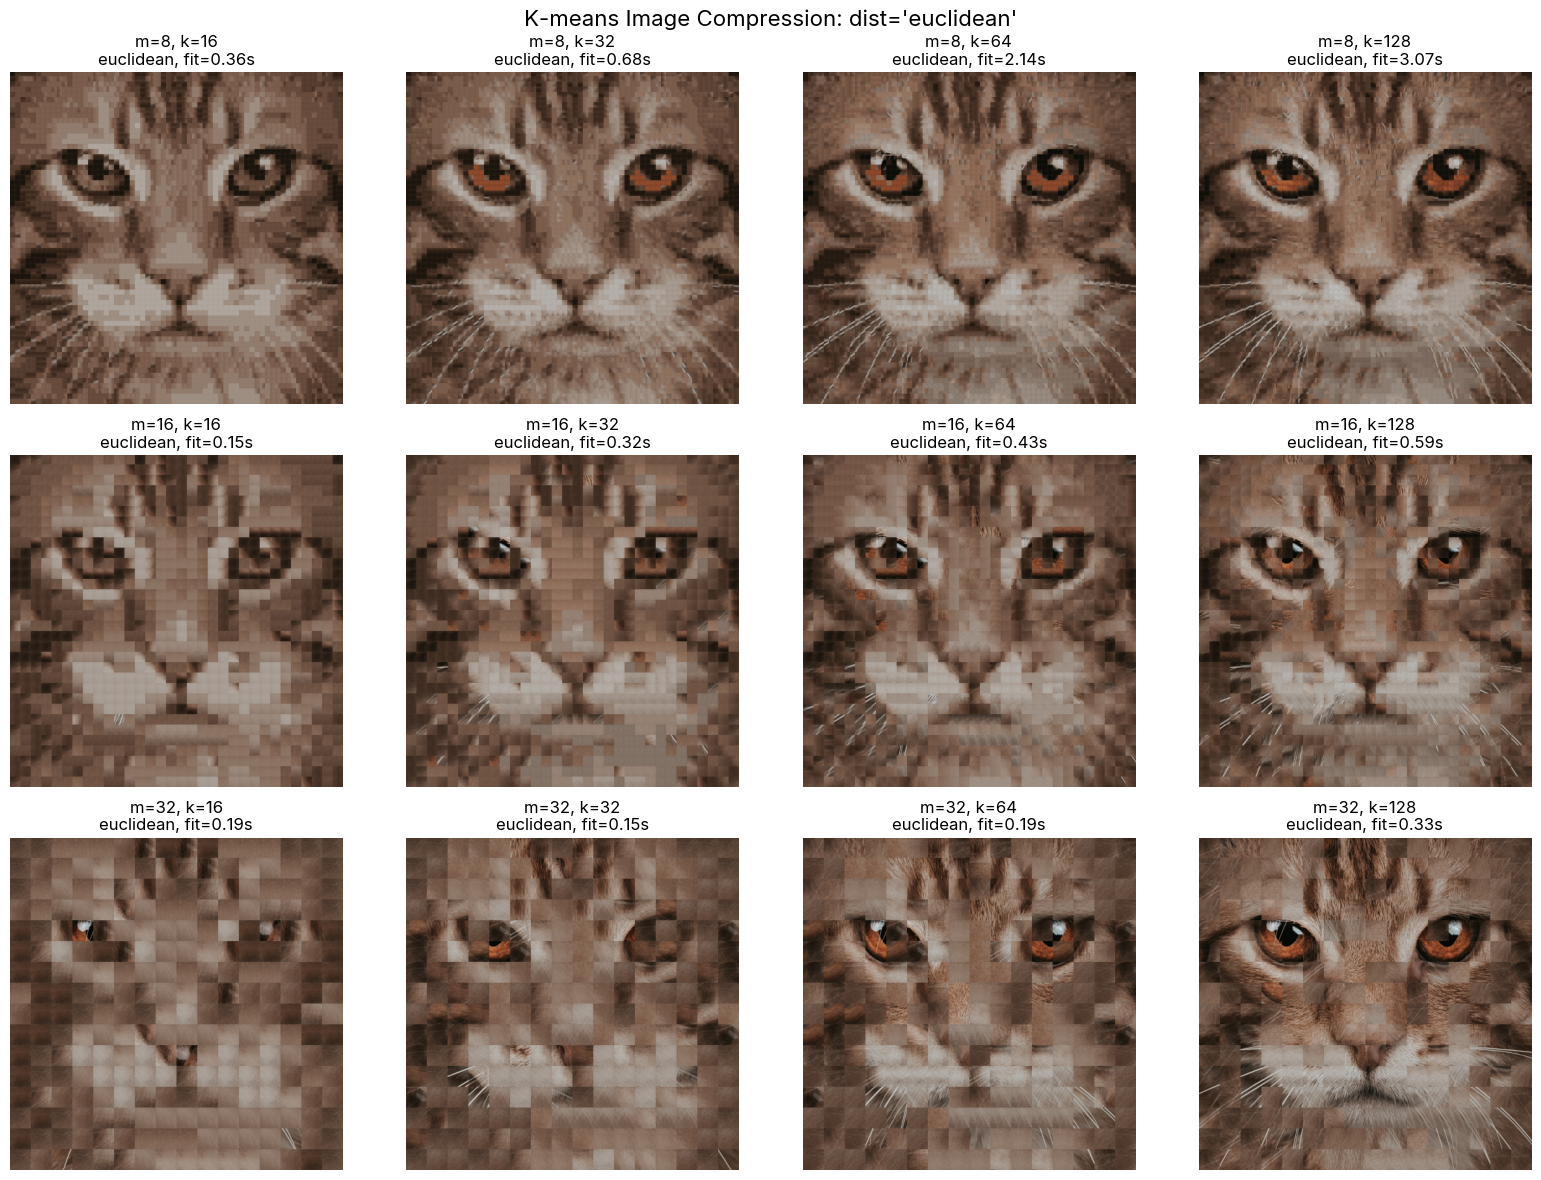

In [12]:
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor


m_list = [8, 16, 32]                 # patch sizes to try
k_list = [16, 32, 64, 128]               # number of clusters
dist_metric = 'euclidean'            # change to: 'cityblock' | 'chebyshev' | 'cosine' etc.
max_iter = 400



img = img.resize((512, 512))
img_tensor = ToTensor()(img).contiguous()    # (3, 512, 512)

def flatten_patches(patches):
    # input: (N, 3, m, m) -> (N, 3*m*m)
    n, c, m, _ = patches.shape
    return patches.reshape(n, c*m*m)

def reconstruct_from_predictions(predicted, centroids, n_patches, m):
    """
    Handles both:
      - predicted = labels (N,)
      - predicted = reconstructed vectors (N, D)
    Returns (N, 3, m, m)
    """
    if predicted.ndim == 1:  # labels
        recon = centroids[predicted]
    else:                    # already vectors
        recon = predicted
    return recon.reshape(n_patches, 3, m, m)

# Collect results
fit_times = np.zeros((len(m_list), len(k_list)), dtype=float)

# Create a big figure of reconstructions: rows=patch sizes, cols=cluster counts
fig_recon, axs_recon = plt.subplots(len(m_list), len(k_list), figsize=(4*len(k_list), 4*len(m_list)))
if len(m_list) == 1 and len(k_list) == 1:
    axs_recon = np.array([[axs_recon]])  # normalize indexing
elif len(m_list) == 1:
    axs_recon = np.array([axs_recon])
elif len(k_list) == 1:
    axs_recon = axs_recon[:, np.newaxis]

for i_m, m in enumerate(tqdm(m_list)):
    # Make patches for this patch size
    patches = to_patches(img_tensor, m)            # expected shape: (N, 3, m, m)
    N = patches.shape[0]
    data = flatten_patches(patches)                # (N, D)
    D = data.shape[1]

    for j_k, k in enumerate(tqdm(k_list)):
        # Initialize and fit
        kmeans = KMeans(k, D, max_iter=max_iter, dist_metric=dist_metric)

        t0 = time.perf_counter()
        centroids = kmeans.fit(data)               # centroids: (k, D)
        t1 = time.perf_counter()
        fit_time = t1 - t0

        # Predict (labels or recon)
        predicted = kmeans.predict(data, centroids)  # could be (N,) labels or (N, D) recon vectors

        # Reconstruct patches for visualization
        recon_patches = reconstruct_from_predictions(predicted, centroids, N, m)
        recon_img = visualize_patches(recon_patches)  # expected to return HxWx3 image array

        # Log
        fit_times[i_m, j_k] = fit_time
        print(f"[m={m:>2}, k={k:>3}] fit_time = {fit_time:.3f} s")

        # Show reconstruction
        ax = axs_recon[i_m, j_k]
        ax.imshow(recon_img)
        ax.set_title(f"m={m}, k={k}\n{dist_metric}, fit={fit_time:.2f}s")
        ax.axis('off')

fig_recon.suptitle(f"K-means Image Compression: dist='{dist_metric}'", fontsize=16)
fig_recon.tight_layout()
plt.show()


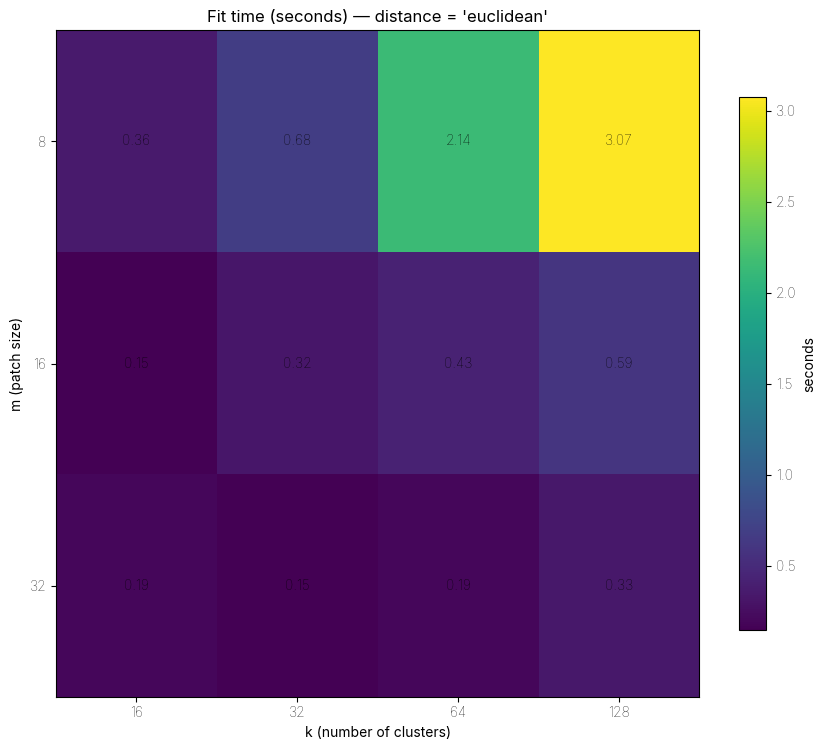

In [13]:
fig_time, ax_time = plt.subplots(1, 1, figsize=(1.2*len(k_list)+4, 1.2*len(m_list)+4))
im = ax_time.imshow(fit_times, aspect='auto')

# Tick labels
ax_time.set_xticks(np.arange(len(k_list)))
ax_time.set_xticklabels([str(k) for k in k_list])
ax_time.set_yticks(np.arange(len(m_list)))
ax_time.set_yticklabels([str(m) for m in m_list])

ax_time.set_xlabel("k (number of clusters)")
ax_time.set_ylabel("m (patch size)")
ax_time.set_title(f"Fit time (seconds) — distance = '{dist_metric}'")

# Annotate each cell with the time
for i in range(len(m_list)):
    for j in range(len(k_list)):
        ax_time.text(j, i, f"{fit_times[i, j]:.2f}", ha="center", va="center")

fig_time.colorbar(im, ax=ax_time, shrink=0.8, label="seconds")
fig_time.tight_layout()
plt.show()

- We can see that the quality improves as **m $\rightarrow$ smaller** and **k $\rightarrow$ larger** (meaning less compression).
- When **m** and **k** are both small, the image looks smoother and flatter - colors and brightness are more uniform but less detailed.
- When **m** and **k** are both large, the image becomes patchy and looks somewhat "broken", but it keeps better brightness and color variation.

We do like the option with **smaller m** and increasing the number of clusters k, as it gives a good balance between quality and compression. It requires more computation time, but the algorithm can be quite efficient - possibly even faster than the current implementation.

For the provided example, the best setting is `m = 8, k = 32`.

---

\### **YOUR ANSWER HERE** \###

---

In [14]:
m = 16 # size of patch
img = img.resize((512,512))
img_tensor = ToTensor()(img) # 3, 512, 512

patches = to_patches(img_tensor, m)
patches.shape

# convert patch data to feature vectors
data = patches.reshape(patches.shape[0], -1)
data.shape

(1024, 768)

## 3. Elbow method (1.4 pt)

In this task, we will use the Elbow method to visualize the trade-off between quality and number of clusters $k$ and try to select the best one!

##### To do some preliminary reading about Elbow Method, please, check the following link:
- https://stackabuse.com/k-means-clustering-with-the-elbow-method/

### Task 3: Implementation (0.4 pt)
Here we will implement the calculation of **Distortion** or **Inertia**, which are basically squared distances from each point to its assigned centroid.

In [15]:
## For each k run clustering algorithm and compute it's Distortion value
def calc_distoriton(data: np.ndarray, centroids:np.ndarray) -> float: # TODO: why dont we pass the metric here?
    distortion = 0
    # ========= YOUR CODE STARTS HERE ========= #

    dist2closest = cdist(data, centroids).min(axis=1)
    distortion = np.power(dist2closest, 2).mean()

    # ========== YOUR CODE ENDS HERE ========== #
    return distortion

### Task 4: Calculate & Visualize (0.5 pt)
Let's use above implemented function to calculate distortion for some $k$ values and visualize our results

100%|██████████| 31/31 [00:09<00:00,  3.38it/s]


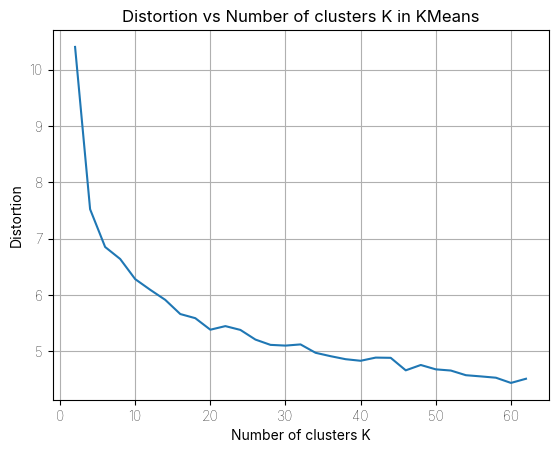

In [16]:
from tqdm import tqdm

# You can choose your own values for the range
#(it may take some time to run the loop, so feel free to optimize your code ;=)
k_min = 2
k_max = 64
k_range = range(k_min, k_max, 2)

distortions = list()
#calculate distortion values
for k in tqdm(k_range):
  # ========= YOUR CODE STARTS HERE ========= #

    kmeans = KMeans(k, data.shape[-1], max_iter=300)
    centroids = kmeans.fit(data)
    
    distortion = calc_distoriton(data, centroids)
    distortions.append(distortion)

  # ========== YOUR CODE ENDS HERE ========== #

# Plot your results
# ========= YOUR CODE STARTS HERE ========= #
import matplotlib.pyplot as plt

plt.plot(list(k_range), distortions)
plt.xlabel("Number of clusters K")
plt.ylabel("Distortion")
plt.title("Distortion vs Number of clusters K in KMeans")
plt.grid(True)

# ========== YOUR CODE ENDS HERE ========== #

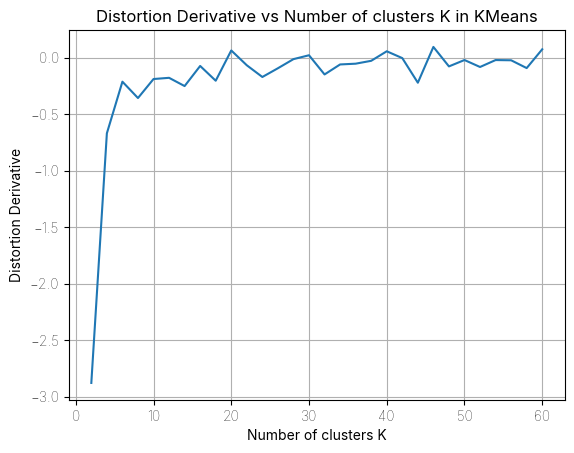

In [17]:
distortions_dv = [
    distortions[ii] - distortions[ii-1]
    for ii in range(1, len(distortions))
    ]

plt.plot(list(k_range[:-1]), distortions_dv)
plt.xlabel("Number of clusters K")
plt.ylabel("Distortion Derivative")
plt.title("Distortion Derivative vs Number of clusters K in KMeans")
plt.grid(True)

### Task 5: Summarize (0.5 pt)

Discuss your results: what is the best trade-off between number of clusters and distortion?

What is the compression rate with this optimal value?

---

\### **YOUR ANSWER HERE** \###

---

The best trade-off is `k = 8` (based on the second chart), the derivative reaches it's following values mean point (following values can be considered as noise)

Compression rate:
1. Initial pixels count: $512 \times 512 = 262 144$
2. Pixels in the patch: $16 \times 16 = 256$
3. Centroids to store: $8$
4. Final compression rate: $262 144 : (256 \times 6) = 170$

---

\### **YOUR ANSWER HERE** \###

---

## 4. Conclusions (0.6 pt)

---


### Task 6 (0.6 pt)
Summarize in a few sentences what you have learned and achieved by completing the tasks of this assignment

---

\### **YOUR ANSWER HERE** \###

---

We were already familiar with the k-means algorithm, so the main challenge was to implement it efficiently - avoiding python loops and relying on*vectorized operations. It was interesting to challenge ourselves to design an optimized implementation and gain more practice with broadcasting.

The general idea of image compression using clustering was also very engaging. It was our first experience building such a method from scratch, and it gave us valuable insight into how classical algorithms can be applied to real-world problems like image compression.

---

\### **YOUR ANSWER HERE** \###

---

## 5. Bonus Problem (0.5 pt)
Besides compression, K-Means clustering can be used in more "creative" way -- using bigger patch sizes we can create cool "pop-art" mosaics :=)

*Hint*: you can replace fitted centroids with your own patches.

In [18]:
# ========= YOUR CODE STARTS HERE ========= #

# ========== YOUR CODE ENDS HERE ========== #